<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agenteval_cq_math.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstrating the `AgentEval` framework using the task of solving math problems as an example

This notebook aims to demonstrate how to `AgentEval` implemented through [AutoGen](https://github.com/microsoft/autogen) works, where we use a math problem-solving task as an example. 
`AgentEval` consists of two key components:

- `CriticAgent`: This is an LLM-based agent that generates a list criteria $(c_1, \dots, c_n)$ to help to evaluate a utility given task.

- `QuantifierAgent`: This agent quantifies the performance of any sample task based on the criteria designed by the `CriticAgent` in the following way: $(c_1=a_1, \dots, c_n=a_n)$

![AgentEval](../website/blog/2023-11-20-AgentEval/img/agenteval-CQ.png)

For more detailed explanations, please refer to the accompanying [blog post](https://microsoft.github.io/autogen/blog/2023/11/20/AgentEval)

## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install pyautogen, Docker, and OpenAI:


In [ ]:
%pip install pyautogen~=0.2.0b5 docker
%pip install scipy
%pip install matplotlib

## Set your API Endpoint

* The [`config_list_openai_aoai`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_openai_aoai) function tries to create a list of configurations using Azure OpenAI endpoints and OpenAI endpoints. It assumes the api keys and api bases are stored in the corresponding environment variables or local txt files:
  - OpenAI API key: os.environ["OPENAI_API_KEY"] or `openai_api_key_file="key_openai.txt"`.
  - Azure OpenAI API key: os.environ["AZURE_OPENAI_API_KEY"] or `aoai_api_key_file="key_aoai.txt"`. Multiple keys can be stored, one per line.
  - Azure OpenAI API base: os.environ["AZURE_OPENAI_API_BASE"] or `aoai_api_base_file="base_aoai.txt"`. Multiple bases can be stored, one per line.
* The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file. It first looks for an environment variable with a specified name. The value of the environment variable needs to be a valid json string. If that variable is not found, it looks for a json file with the same name. It filters the configs by filter_dict.

You can set the value of config_list in any way you prefer. Please refer to this [notebook](https://github.com/microsoft/autogen/blob/main/notebook/oai_openai_utils.ipynb) for full code examples of the different methods.


In [ ]:
import autogen

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4"],
    },
)


## Construct `CriticAgent`

We construct the planning agent named `critic` and a user proxy agent for the critic named `critic_user`. We specify `human_input_mode` as "NEVER" in the user proxy agent, ensuring that it will never ask for human feedback. Additionally, we define the `ask_critic` function to send a message to the critic and retrieve the criteria from the critic.


In [3]:

critic = autogen.AssistantAgent(
    name = "critic",
    llm_config = {"config_list": config_list},
    system_message = """You are a helpful assistant. You suggest criteria for evaluating different tasks. They should be dinstinguishable, quantifieable and not redundant.
    Convert the evaluation criteria into a dictionary where the keys are the criteria.
    The value of each key is a dictionary as follows {"description": criteria description , "accepted_values": possible accepted inputs for this key}
    Make sure the keys are criteria for assessing the given task.  "accepted_values" include the acceptable inputs for each key that are fine-grained and preferrably mlti-graded levels. "description" includes the criterion description.
    Return the dictionary."""
)

critic_user = autogen.UserProxyAgent(
    name = "critic_user",
    max_consecutive_auto_reply = 0,  # terminate without auto-reply
    human_input_mode = "NEVER",
)

def ask_critic(message):
    """
    Initiate a chat with the critic user and return the last message received from the planner.

    Args:
    - message (str): The message to be sent to the critic user.

    Returns:
    - str: The content of the last message received.
    """
    critic_user.initiate_chat(critic, message=message)
    # return the last received from the planner
    return critic_user.messagelast_message()["content"]



# Run the Critic

To run the critic, we need a couple of math problem examples. One of them failed to solve the problem successfully, given in `agenteval-in-out/response_failed.txt`, and the other one was solved successfully, i.e., `agenteval-in-out/response_successful.txt`.

In [14]:
def read_without_groundtruth(file_name):
    """
    Read the mathproblem logs - bypassing any information about the ground truths.

    Args:
    - file_name (str): The single log file that wants to get evaluated.

    Returns:
    - str: The log file without any information about the ground truth answer of the problem.
    """
    f = open( file_name,"r").readlines()
    output_dictionary = ""
    for line in f:
          if "is_correct" not in line and "correct_ans" not in line and  "check_result"  not in line:
              output_dictionary += line
          elif "is_correct" in line:
                correctness = line.replace(",","").split(":")[-1].rstrip().strip()
    return [output_dictionary,correctness]

# Reading one successful and one failed example of the task
response_successful = read_without_groundtruth("../test/test_files/agenteval-in-out/samples/sample_math_response_successful.txt")[0]
response_failed = read_without_groundtruth("../test/test_files/agenteval-in-out/samples/sample_math_response_failed.txt")[0]

task = {"name": "Math problem solving",
      "description": "Given any question, the system needs to  solve the problem as consisely and  acccurately as possible",
      "successful_response" : response_successful,
      "failed_response" : response_failed}

sys_msg = f"""Task: {task["name"]}.
Task description: {task["description"]}
Task successfull example: {task["successful_response"]}
Task failed example: {task["failed_response"]}
"""


# The Criteria
Now, we print the designed criteria for assessing math problems. 

In [15]:

current_task_name = '_'.join(task["name"].split()).lower()
gen_criteria = critic_user.initiate_chat(critic, message=sys_msg)
criteria = critic_user.last_message()
cr_file = open(f"../test/test_files/agenteval-in-out/{current_task_name}_criteria.json","w")
cr_file.write(criteria["content"])
cr_file.close()

critic_user (to critic):

Task: Math problem solving.
Task description: Given any question, the system needs to  solve the problem as consisely and  acccurately as possible
Task successfull example: {
  "problem": "What is the sum of all the distinct positive two-digit factors of 144?",
  "level": "Level 5",
  "type": "Number Theory",
  "solution": "Prime factorize $144=2^4\\cdot3^2$. The sum of the positive two-digit factors of 144 is $2^4+2\\cdot3^2+2^2\\cdot3+2^2\\cdot3^2+2^3\\cdot3+2^3\\cdot3^2+2^4\\cdot3=\\boxed{226}.$",
  "problem_id": "0",
  "response_with_ans": "To find the sum of all the distinct positive two-digit factors of 144, we need to first find all these factors. We can do this by iterating through the numbers from 10 to 99 and checking if they are factors of 144. Then, we can sum these factors and print their sum.\n\nHere's a Python script to accomplish this:\n\n```python\ntwo_digit_factors = []\n\nfor i in range(10, 100):\n    if 144 % i == 0:\n        two_digit_fact

*Note :* You can also define and use your own criteria by editing `criteria.txt`

# The `QuantifierAgent`

Once we have the criteria, we need to quantify a new sample based on the designed criteria and its accepted values. This will be done through `QuantifierAgent` agent as follows. 
We note that can skip the designed creteria by the agent and use your own defined criteria in `criteria_file`.

In [17]:
import json

criteria_file = f"../test/test_files/agenteval-in-out/{current_task_name}_criteria.json"
quantifier = autogen.AssistantAgent(
    name = "quantifier",
    llm_config = {"config_list": config_list},
    system_message = """You are a helpful assistant. You quantify the output of different tasks based on the given criteria.
    The criterion is given in a dictionary format where each key is a dintinct criteria.
    The value of each key is a dictionary as follows {"description": criteria description , "accepted_values": possible accepted inputs for this key}
    You are going to quantify each of the crieria for a given task based on the task decription.
    Return a dictionary where the keys are the criteria and the values are the assessed performance based on accepted values for each criteria.
    Return only the dictionary."""
)

quantifier_user = autogen.UserProxyAgent(
    name = "quantifier_user",
    max_consecutive_auto_reply = 0,  # terminate without auto-reply
    human_input_mode = "NEVER",
)

dictionary_for_eval = open(criteria_file,"r").read()




## Running the quantifier on a single test case

In [18]:
import os

def get_quantifier(file,criteria_file):
  """
  Running quantifier agent on individual log.

  Args:
  - file (str): The log path.
  - file (str): The criteria jason file path
  Returns:
  - dict: A dictionary including the actual success of the problem as well as estimated performance by the agent eval.
  {"actual_success":actual_label, "estimated_performance" : a dictionary of all the criteria and their quantified estimated performance.} }
  """
  dictionary_for_eval = open(criteria_file,"r").read()

  test_case , actual_label = read_without_groundtruth(file)
  print("actual label for this case: ", actual_label)
  cq_results = quantifier_user.initiate_chat(quantifier, message = sys_msg + \
                                "Evaluation dictionary: " + str(dictionary_for_eval) +\
                                "actual test case to evaluate: " + test_case)
  quantified_results = quantifier_user.last_message()
  return {"actual_success": actual_label, "estimated_performance": quantified_results["content"]}



Here, we run the quantifier on a single math problem test case, `sample_test_case.json`, for demonstration.

In [19]:
test_case = "../test/test_files/agenteval-in-out/samples/sample_test_case.json"
quantifier_output = get_quantifier(test_case,criteria_file)
print("actual correctness:" , quantifier_output["actual_success"])
print("predicted coprrectness:\n" , quantifier_output["estimated_performance"])

actual label for this case:  true
quantifier_user (to quantifier):

Task: Math problem solving.
Task description: Given any question, the system needs to  solve the problem as consisely and  acccurately as possible
Task successfull example: {
  "problem": "What is the sum of all the distinct positive two-digit factors of 144?",
  "level": "Level 5",
  "type": "Number Theory",
  "solution": "Prime factorize $144=2^4\\cdot3^2$. The sum of the positive two-digit factors of 144 is $2^4+2\\cdot3^2+2^2\\cdot3+2^2\\cdot3^2+2^3\\cdot3+2^3\\cdot3^2+2^4\\cdot3=\\boxed{226}.$",
  "problem_id": "0",
  "response_with_ans": "To find the sum of all the distinct positive two-digit factors of 144, we need to first find all these factors. We can do this by iterating through the numbers from 10 to 99 and checking if they are factors of 144. Then, we can sum these factors and print their sum.\n\nHere's a Python script to accomplish this:\n\n```python\ntwo_digit_factors = []\n\nfor i in range(10, 100):\n  

# Run `AgentEval` on the logs

In the example below, log_path points to the sample logs folder to run the quantifier. The current sample belongs to the prealgebra category which will be downloaded from [here](https://github.com/julianakiseleva/autogen/tree/agenteval/test/test_files/agenteval-in-out/samples).
In case you want to replicate the results described in the blog post, you can download all the logs for math problems using the following [link](https://github.com/julianakiseleva/autogen/tree/agenteval/model-logs/math-problems/agentchat). 

In [ ]:
!wget https://github.com/julianakiseleva/autogen/blob/agenteval/test/test_files/agenteval-in-out/samples/prealgebra.zip 
!unzip z.zip -d ../test/test_files/agenteval-in-out/agentchat_results
!rm  prealgebra.zip 

In [ ]:
# You can set your own log path - we also limited the number of samples to avoid additional costs.
# By removing the condition about limitations on the number of samples per category, you can run it on all 120 problems

log_path = "../test/test_files/agenteval-in-out/agentchat_results/"
criteria_file = "../test/test_files/agenteval-in-out/samples/sample_math_criteria.json"
outcome = {}

for prefix in os.listdir(log_path):
    for file_name in os.listdir(log_path+"/"+prefix):
        gameid = prefix+"_"+file_name
        if file_name.split('.')[-1]=='json':
            outcome[gameid] = get_quantifier(log_path+"/"+prefix+"/"+file_name,criteria_file)

# store the evaluated problems
with open("../test/test_files/agenteval-in-out/evaluated_problems.json","w") as file:
    json.dump(outcome,file,indent=2) # use `json.loads` to do the reverse

## Plotting the estimated performance

Here you can find an example of how to visualize the obtained result in the histogram form (similar to the one in the blog post).

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# computing average and 95% interval for failed and successful cases on all criteria
try:
  # convert the criteria to dict type if it is already not
        dictionary_for_eval = eval(open(criteria_file,'r').read())
except:
       pass

criteria = list(dictionary_for_eval.keys())
nl2int = {}
for criterion in dictionary_for_eval:
     score = 0
     for v in dictionary_for_eval[criterion]["accepted_values"]:
        nl2int[v] = score
        score += 1
print(nl2int)

average_s = {}
average_f = {}

conf_interval_s = {}
conf_interval_f = {}

for criterion in criteria:
        task={"s": [] , "f" : []}

        for game in outcome:
                try:
                        tmp_dic = eval(outcome[game]["estimated_performance"])
                        if outcome[game]["actual_success"] == "false":
                                task["f"].append(nl2int[tmp_dic[criterion]])
                        else:
                                task["s"].append(nl2int[tmp_dic[criterion]])
                except:
                        pass

          
        average_f[criterion] = np.mean(task['f'])
        average_s[criterion] = np.mean(task['s'])

        conf_interval_s[criterion] = stats.norm.interval(0.95, loc=np.mean(task['s']), scale=stats.sem(task['s']))
        conf_interval_f[criterion] = stats.norm.interval(0.95, loc=np.mean(task['f']), scale=stats.sem(task['f']))


The final plot would be saved in `../test/test_files/agenteval-in-out/estimated_performance.png`

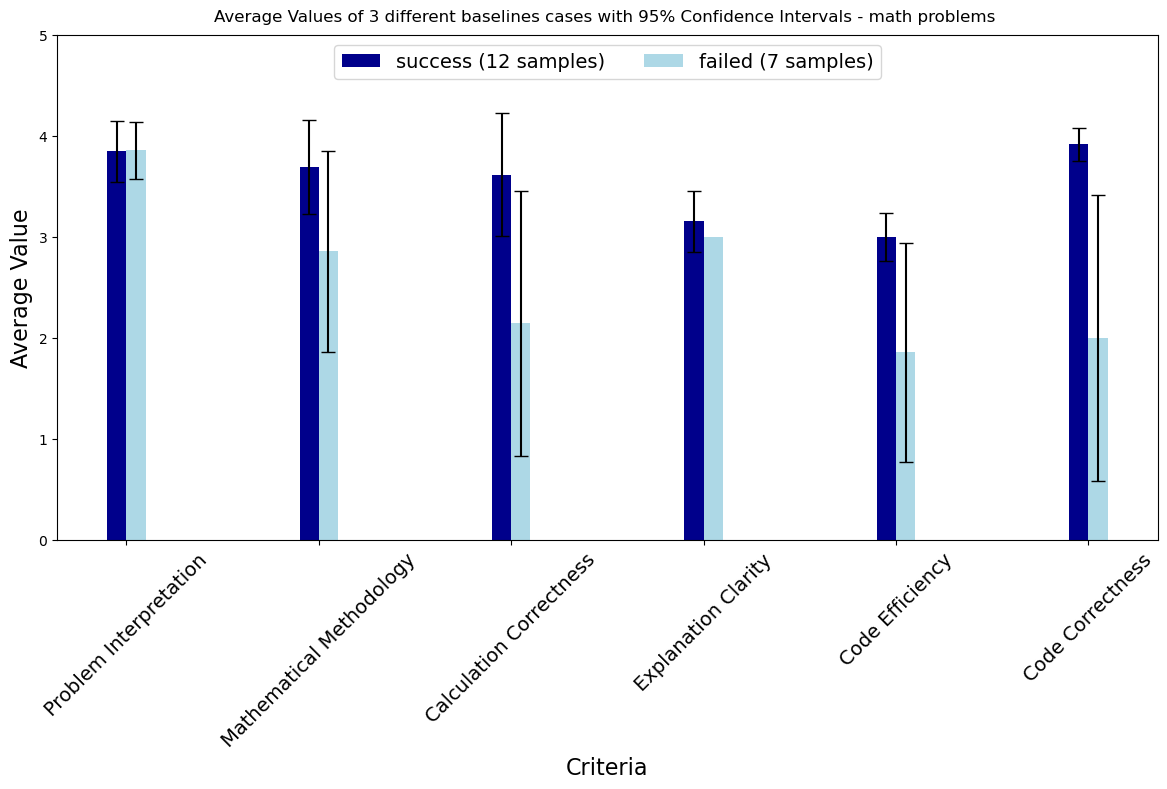

In [22]:
# Create a bar plot with error bars for the average values of "s" and "f" for each criterion

plt.figure(figsize=(12, 8))
bar_width = 0.1
index = np.arange(len(criteria))


plt.bar(index , list(average_s.values()), bar_width, label=f"success ({len(task['s'])} samples)", color="darkblue", yerr=[(avg - conf_interval_s[key][0]) for key, avg in average_s.items()], capsize=5)
plt.bar(index + bar_width, list(average_f.values()), bar_width, label=f"failed ({len(task['f'])} samples)", color="lightblue", yerr=[(avg - conf_interval_f[key][0]) for key, avg in average_f.items()], capsize=5)

plt.xlabel("Criteria", fontsize=16)
plt.ylabel("Average Value", fontsize=16)
plt.title("Average Values of 3 different baselines cases with 95% Confidence Intervals - math problems ", fontsize=12, pad=10)  # Adjust titlepad to move the title further above
plt.xticks(index + bar_width / 2, criteria, rotation=45, fontsize=14)
plt.legend(loc="upper center", fontsize=14, bbox_to_anchor=(0.5, 1), ncol=3)  # Adjust legend placement and ncol
plt.tight_layout()  # Adjust subplot parameters to fit the labels
plt.ylim(0,5)
plt.savefig("../test/test_files/agenteval-in-out/estimated_performance.png")
plt.show()
